In [14]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

In [15]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#w = cluster.scale(jobs=2)
#
client = Client(cluster)

In [3]:
# Load Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'

In [4]:
parcels_index = 'filtered_itide_Tw30_sd_band04'
#'lpass_filtered_iprime_05cpd'
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df.head()


trajectory        lat         lon    z  zonal_velocity  \
time                                                                 
2011-11-15     2000844 -67.226303    0.562500  0.0             0.0   
2011-11-15    32001255 -69.530426 -126.770836  0.0             0.0   
2011-11-15    24000949 -40.126877  163.312500  0.0             0.0   
2011-11-15    32001165 -65.565285 -130.937500  0.0             0.0   
2011-11-15    24001270 -29.922403  177.895828  0.0             0.0   

            meridional_velocity  waterdepth  zonal_velocity_hat_real  \
time                                                                   
2011-11-15                  0.0         0.0                 0.002438   
2011-11-15                  0.0         0.0                 0.000518   
2011-11-15                  0.0         0.0                 0.028092   
2011-11-15                  0.0         0.0                -0.004214   
2011-11-15                  0.0         0.0                -0.027028   

            zonal_velocity_hat_imag  zonal_velocity_demodulated_real  \
time                                                                   
2011-11-15                 0.002383                         0.002438   
2011-11-15                -0.006434                         0.000518   
2011-11-15                 0.000022                         0.028092   
2011-11-15                -0.001272                        -0.004214   
2011-11-15                 0.013208                        -0.027028   

            zonal_velocity_demodulated_imag  meridional_velocity_hat_real  \
time                                                                        
2011-11-15                         0.002383                     -0.001410   
2011-11-15                        -0.006434                      0.002277   
2011-11-15                         0.000022                     -0.018097   
2011-11-15                        -0.001272                      0.000220   
2011-11-15                         0.013208                      0.014038   

            meridional_velocity_hat_imag  \
time                                       
2011-11-15                      0.005584   
2011-11-15                     -0.000432   
2011-11-15                     -0.020551   
2011-11-15                     -0.000716   
2011-11-15                      0.009028   

            meridional_velocity_demodulated_real  \
time                                               
2011-11-15                             -0.001410   
2011-11-15                              0.002277   
2011-11-15                             -0.018097   
2011-11-15                              0.000220   
2011-11-15                              0.014038   

            meridional_velocity_demodulated_imag  
time                                              
2011-11-15                              0.005584  
2011-11-15                             -0.000432  
2011-11-15                             -0.020551  
2011-11-15                             -0.000716  
2011-11-15                              0.009028

In [ ]:
df = df.reset_index().persist()

In [6]:
time = df.time.compute()

In [11]:
time = np.unique(time)

In [14]:
df0 = df.loc[time[0]].persist()

In [15]:
traj0 = df0.trajectory.values.compute()

In [16]:
df_traj0 = df[df.trajectory.isin(traj0)]

In [18]:
df_traj0 = df_traj0.persist()

In [5]:
def remove_duplicates(df):
    """Find duplicates in dataframe and remove them.
    Create a column 'dt_flag', False if the dt is not different from 1/24
    
    ----------------
    Parameters
    df : dataframe from which duplicates must be removed, dataframe
    
    ----------------
    Returns
    df : input dataframe without duplicates and with new column 'dt_flag', dataframe
    """
#    df = df.reset_index().drop_duplicates('time').sort_values('time')#.set_index('time')
    df = df.drop_duplicates('time').set_index('time')
#    dt_df = df.index[1:]-df.index[:-1]
#    df['dt_flag'] = np.insert(dt_df!=np.timedelta64(1,'h'),0,False)
    return df

In [17]:
#df = df_traj0
# Remove duplicates found in dataframe and create flag column to check that dt is always 1/24
df_drop = df.reset_index().groupby('trajectory').apply(remove_duplicates#,meta=meta
                                   ).persist()
df_drop.head()

/dev/shm/pbs.443548.datarmor0/ipykernel_29946/997324232.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_drop = df.reset_index().groupby('trajectory').apply(remove_duplicates#,meta=meta


KeyboardInterrupt: 

In [10]:
print(df.zonal_velocity.size.compute(),df_drop.zonal_velocity.size.compute())

593657072 593657072


In [5]:
time = df.index.compute()

In [9]:
dT = np.unique(time).size

In [12]:
df.groupby('trajectory').apply(lambda df : np.unique(df.index).size).persist()

/dev/shm/pbs.297925.datarmor0/ipykernel_39672/3407009543.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df.groupby('trajectory').apply(lambda df : np.unique(df.index).size).persist()


Dask Series Structure:
npartitions=707
    int64
      ...
    ...  
      ...
      ...
dtype: int64
Dask Name: lambda, 707 tasks

In [53]:
df = df.loc[:'2012-09-30 00:00:00']

In [5]:
V = 'demodulated'
df['zonal_velocity_'+V] = df['zonal_velocity_'+V+'_real']+1j*df['zonal_velocity_'+V+'_imag']
df['energy_SSU'] = df['zonal_velocity_'+V].apply(lambda x : np.abs(x)**2)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('zonal_velocity_demodulated', 'float64'))

  warnings.warn(meta_warning(meta))


In [6]:
df['meridional_velocity_'+V] = df['meridional_velocity_'+V+'_real']+1j*df['meridional_velocity_'+V+'_imag']
df['energy_SSV'] = df['meridional_velocity_'+V].apply(lambda x : np.abs(x)**2)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('meridional_velocity_demodulated', 'float64'))

  warnings.warn(meta_warning(meta))


In [7]:
df['energy'] = (df['energy_SSU']+df['energy_SSV'])

In [8]:
df.head()

trajectory        lat         lon    z  zonal_velocity  \
time                                                                 
2011-11-15     2000844 -67.226303    0.562500  0.0             0.0   
2011-11-15    32001255 -69.530426 -126.770836  0.0             0.0   
2011-11-15    24000949 -40.126877  163.312500  0.0             0.0   
2011-11-15    32001165 -65.565285 -130.937500  0.0             0.0   
2011-11-15    24001270 -29.922403  177.895828  0.0             0.0   

            meridional_velocity  waterdepth  zonal_velocity_hat_real  \
time                                                                   
2011-11-15                  0.0         0.0                 0.002438   
2011-11-15                  0.0         0.0                 0.000518   
2011-11-15                  0.0         0.0                 0.028092   
2011-11-15                  0.0         0.0                -0.004214   
2011-11-15                  0.0         0.0                -0.027028   

            zonal_velocity_hat_imag  zonal_velocity_demodulated_real  \
time                                                                   
2011-11-15                 0.002383                         0.002438   
2011-11-15                -0.006434                         0.000518   
2011-11-15                 0.000022                         0.028092   
2011-11-15                -0.001272                        -0.004214   
2011-11-15                 0.013208                        -0.027028   

            zonal_velocity_demodulated_imag  meridional_velocity_hat_real  \
time                                                                        
2011-11-15                         0.002383                     -0.001410   
2011-11-15                        -0.006434                      0.002277   
2011-11-15                         0.000022                     -0.018097   
2011-11-15                        -0.001272                      0.000220   
2011-11-15                         0.013208                      0.014038   

            meridional_velocity_hat_imag  \
time                                       
2011-11-15                      0.005584   
2011-11-15                     -0.000432   
2011-11-15                     -0.020551   
2011-11-15                     -0.000716   
2011-11-15                      0.009028   

            meridional_velocity_demodulated_real  \
time                                               
2011-11-15                             -0.001410   
2011-11-15                              0.002277   
2011-11-15                             -0.018097   
2011-11-15                              0.000220   
2011-11-15                              0.014038   

            meridional_velocity_demodulated_imag  zonal_velocity_demodulated  \
time                                                                           
2011-11-15                              0.005584          0.002438+0.002383j   
2011-11-15                             -0.000432          0.000518-0.006434j   
2011-11-15                             -0.020551          0.028092+0.000022j   
2011-11-15                             -0.000716         -0.004214-0.001272j   
2011-11-15                              0.009028         -0.027028+0.013208j   

            energy_SSU  meridional_velocity_demodulated    energy_SSV  \
time                                                                    
2011-11-15    0.000012              -0.001410+0.005584j  3.317340e-05   
2011-11-15    0.000042               0.002277-0.000432j  5.370800e-06   
2011-11-15    0.000789              -0.018097-0.020551j  7.498556e-04   
2011-11-15    0.000019               0.000220-0.000716j  5.616224e-07   
2011-11-15    0.000905               0.014038+0.009028j  2.785740e-04   

              energy  
time                  
2011-11-15  0.000045  
2011-11-15  0.000047  
2011-11-15  0.001539  
2011-11-15  0.000020  
2011-11-15  0.001184

### Load Eulerian dataset

In [16]:
ds_low = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/diags/Eulerian_low_variance.zarr')
#ds_low = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/diags/Eulerian_lf.zarr')
#ds_hf = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/diags/Eulerian_hf_energy.zarr')
ds_hf = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/diags/Eulerian_Eta.zarr')
grd = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/rechunked/SSU_rot.zarr')[['XC','YC']]
ds_low['lon'] = 0*ds_low.face+grd.XC
ds_low['lat'] = 0*ds_low.face+grd.YC

ds_hf['lon'] = 0*ds_hf.face+grd.XC
ds_hf['lat'] = 0*ds_hf.face+grd.YC
ds_hf

/dev/shm/pbs.587806.datarmor0/ipykernel_52350/881960788.py:5: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  grd = xr.open_zarr('/home/datawork-lops-osi/equinox/mit4320/rechunked/SSU_rot.zarr')[['XC','YC']]


<xarray.Dataset>
Dimensions:  (j: 1080, i: 1080, face: 13)
Coordinates:
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    XC       (face, j, i) float32 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    energy   (face, j, i) float64 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
    lat      (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    lon      (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>

In [4]:
ds_hf

<xarray.Dataset>
Dimensions:  (j: 1080, i: 1080, face: 13)
Coordinates:
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
    XC       (face, j, i) float32 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    energy   (face, j, i) float64 dask.array<chunksize=(11, 1080, 1080), meta=np.ndarray>
    lat      (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    lon      (face, j, i) float64 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>

In [11]:
ds_hf['energy'] = (ds_hf.energy_SSU+ds_hf.energy_SSV)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

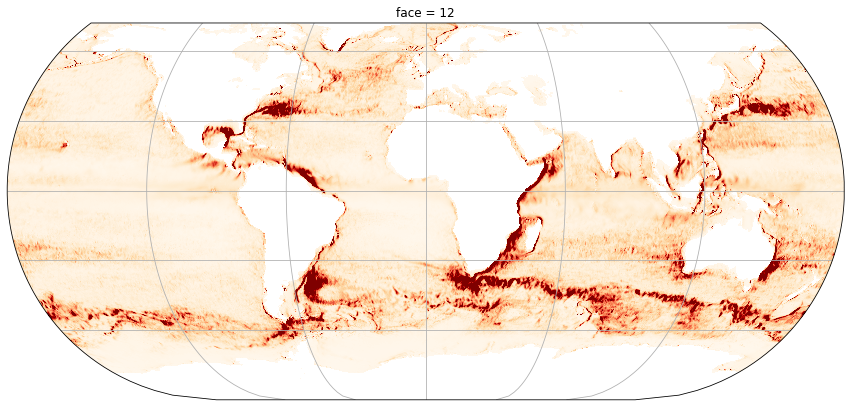

In [9]:
pl.plot_pretty(ds_low.energy_SSV,cmap='OrRd',vmax=0.15,land=False
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

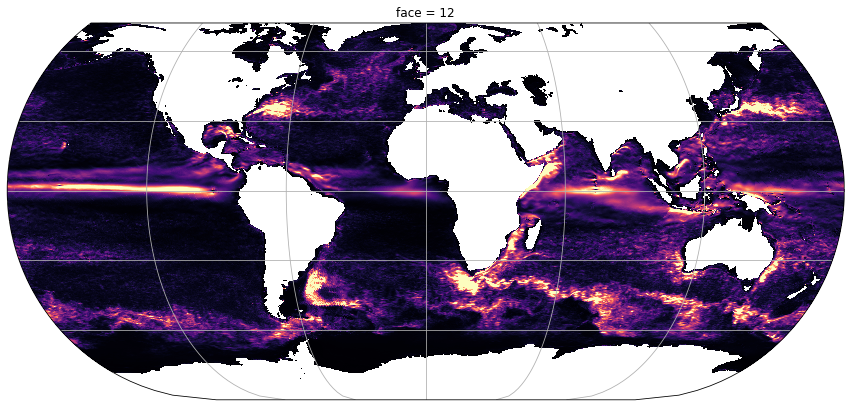

In [10]:
pl.plot_pretty(ds_low.variance_SSU,cmap='magma',vmax=0.15,land=False
              )

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

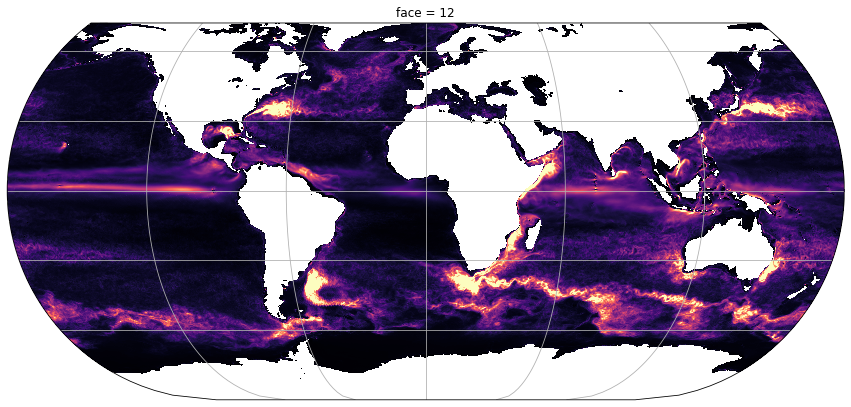

In [7]:
pl.plot_pretty(0.5*(ds_low.variance_SSU+ds_low.variance_SSV),cmap='magma',vmax=0.15,land=False
              )

In [17]:
ds_hf['XC'] = ds_low.XC
ds_hf['YC'] = ds_low.YC

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

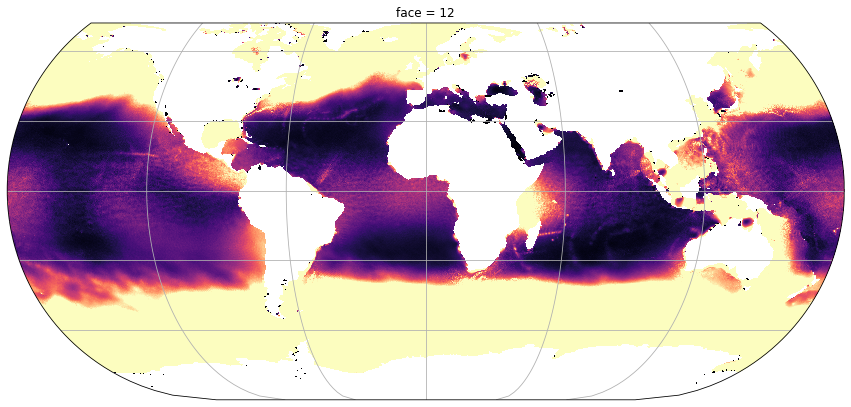

In [18]:
pl.plot_pretty(ds_hf.energy,cmap='magma',vmax=0.0001,land=False)

In [12]:
ds_hf.max()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    energy   float64 dask.array<chunksize=(), meta=np.ndarray>
    lat      float64 dask.array<chunksize=(), meta=np.ndarray>
    lon      float64 dask.array<chunksize=(), meta=np.ndarray>

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

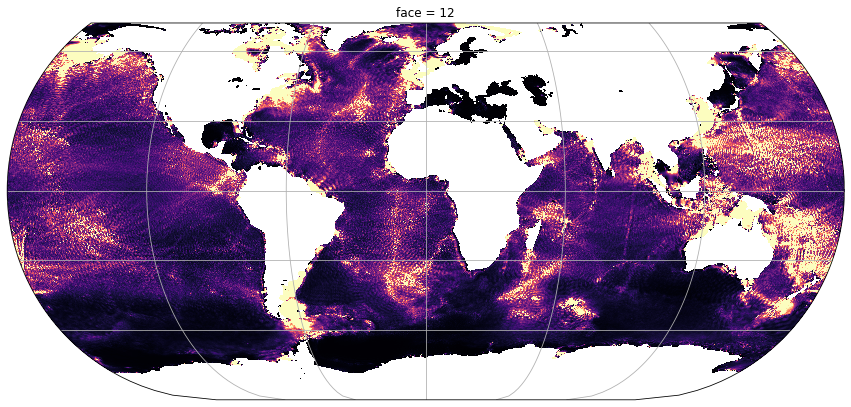

In [6]:
pl.plot_pretty(ds_hf.energy_SSU,cmap='magma',vmax=0.02,land=False)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

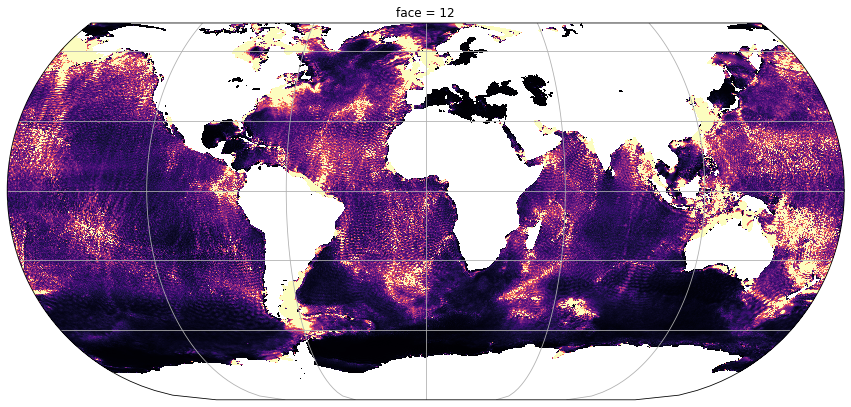

In [7]:
pl.plot_pretty(ds_hf.energy_SSV,cmap='magma',vmax=0.02,land=False)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home1/datahome/zcaspar/miniconda3/e

{'fig': <Figure size 1080x1080 with 1 Axes>,
 'ax': <GeoAxesSubplot:title={'center':'face = 12'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 'cbar': None}

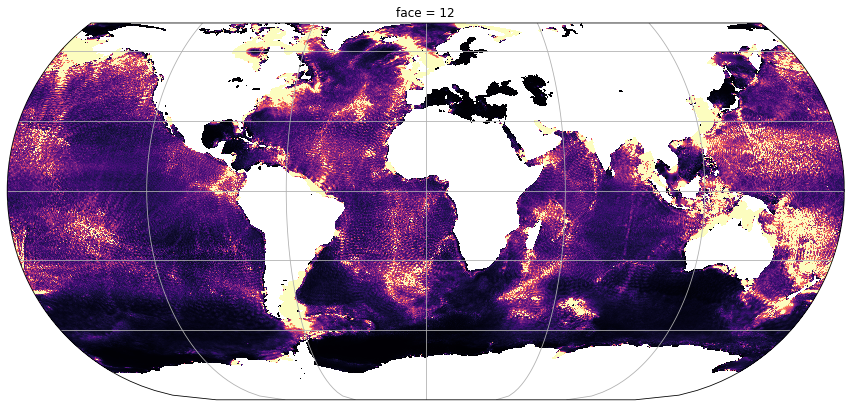

In [9]:
pl.plot_pretty(0.5*(ds_hf.energy_SSU+ds_hf.energy_SSV),cmap='magma',vmax=0.02,land=False)

### Binning

In [19]:
dl = 2.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)
V = 'energy'

In [20]:
N = histogram(ds_low.lon.rename('lon'), ds_low.lat.rename('lat'), 
              bins=[lon_bins,lat_bins], 
              dim=['i', 'j', 'face']
             ).persist()

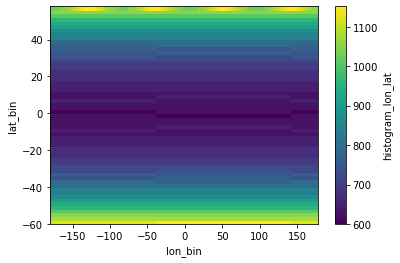

In [21]:
N.plot(y='lat_bin')

In [22]:
ds_binned = (histogram(ds_hf.lon.rename('lon'), ds_hf.lat.rename('lat'),bins=[lon_bins, lat_bins],
                       weights=ds_hf[V].fillna(0.),
                       dim=['i', 'j', 'face'])/(N)).rename('E_%s'%V).persist()

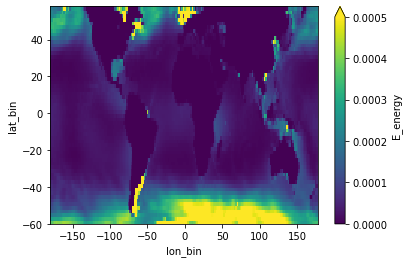

In [23]:
ds_binned.plot(y='lat_bin',vmax=0.0005)

In [24]:
ds_binned = ds_binned.where(ds_binned>0)

In [25]:
dsE = xr.Dataset({'E_count':N,'E_'+V:ds_binned})
dsE = dsE.compute()
dsE

<xarray.Dataset>
Dimensions:   (lon_bin: 179, lat_bin: 59)
Coordinates:
  * lon_bin   (lon_bin) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bin   (lat_bin) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0
Data variables:
    E_count   (lon_bin, lat_bin) int64 1128 1080 1056 1008 ... 1008 1056 1056
    E_energy  (lon_bin, lat_bin) float64 0.0003575 0.0002824 ... 0.0002122

In [42]:
Vl = 'energy'
_df = df[['energy_SSU','energy_SSV','energy','lon','lat','waterdepth','trajectory']]
_df.head()

energy_SSU    energy_SSV    energy         lon        lat  \
time                                                                    
2011-11-15    0.000012  3.317340e-05  0.000045    0.562500 -67.226303   
2011-11-15    0.000042  5.370800e-06  0.000047 -126.770836 -69.530426   
2011-11-15    0.000789  7.498556e-04  0.001539  163.312500 -40.126877   
2011-11-15    0.000019  5.616224e-07  0.000020 -130.937500 -65.565285   
2011-11-15    0.000905  2.785740e-04  0.001184  177.895828 -29.922403   

            waterdepth  trajectory  
time                                
2011-11-15         0.0     2000844  
2011-11-15         0.0    32001255  
2011-11-15         0.0    24000949  
2011-11-15         0.0    32001165  
2011-11-15         0.0    24001270

In [43]:
def binning(_df,binsize):
    #lon_bins,lat_bins = np.arange(lonmin,lonmax,binsize),np.arange(latmin,latmax,binsize)
    x_idx,y_idx = pd.IntervalIndex.from_breaks(lon_bins),pd.IntervalIndex.from_breaks(lat_bins)
    _df['lon_cut'] = _df['lon'].map_partitions(pd.cut, bins=lon_bins)
    _df['lat_cut'] = _df['lat'].map_partitions(pd.cut, bins=lat_bins)
    _df = _df.drop(columns=['lon','lat','trajectory']) # ,'h'
    return _df
_df = binning(_df,dl).persist()

In [27]:
df_mean = _df.groupby(['lon_cut','lat_cut']).mean()
df_mean = df_mean.reset_index().persist()

In [28]:
df_count = _df.groupby(['lon_cut','lat_cut']).count().reset_index().persist()

In [29]:
df_count['lon_bin'] = df_count.lon_cut.apply(lambda x :x.mid)
df_count['lat_bin'] = df_count.lat_cut.apply(lambda x :x.mid)
df_count = df_count.drop(columns=['lon_cut','lat_cut']).compute()
df_count.head()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('lon_cut', 'category'))

  warnings.warn(meta_warning(meta))
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func

energy_SSU  energy_SSV  energy  waterdepth lon_bin lat_bin
0        2122        2122    2122        2122  -179.0   -59.0
1        2306        2306    2306        2306  -179.0   -57.0
2        4807        4807    4807        4807  -179.0   -55.0
3        8811        8811    8811        8811  -179.0   -53.0
4        3768        3768    3768        3768  -179.0   -51.0

In [30]:
df_mean['lon_bin'] = df_mean.lon_cut.apply(lambda x :x.mid)
df_mean['lat_bin'] = df_mean.lat_cut.apply(lambda x :x.mid)
df_mean = df_mean.drop(columns=['lon_cut','lat_cut']).persist()
df_mean.head()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('lon_cut', 'category'))

  warnings.warn(meta_warning(meta))
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3764: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func

energy_SSU  energy_SSV    energy   waterdepth lon_bin lat_bin
0    0.001451    0.001339  0.002790  4554.372762  -179.0   -59.0
1    0.001126    0.000814  0.001940  4994.463140  -179.0   -57.0
2    0.001082    0.001029  0.002110  5290.498440  -179.0   -55.0
3    0.001162    0.000936  0.002097  5250.741119  -179.0   -53.0
4    0.001629    0.001885  0.003515  4786.809979  -179.0   -51.0

In [31]:
df_mean = df_mean.compute()

In [25]:
df_mean

energy_SSU  energy_SSV    energy   waterdepth lon_bin lat_bin
0        0.001947    0.001742  0.003689  4346.939516  -179.5   -59.5
1        0.000816    0.000804  0.001620  4967.515698  -179.5   -58.5
2        0.000295    0.000483  0.000778  5021.588710  -179.5   -57.5
3        0.001090    0.000367  0.001457  5057.304303  -179.5   -56.5
4        0.001176    0.001422  0.002598  5231.297143  -179.5   -55.5
...           ...         ...       ...          ...     ...     ...
42716    0.013508    0.013710  0.027218  1916.349954   178.5    54.5
42717    0.009060    0.009285  0.018345  3428.865027   178.5    55.5
42718    0.008043    0.007528  0.015571  3823.840507   178.5    56.5
42719    0.013667    0.012842  0.026509  3798.901567   178.5    57.5
42720    0.031175    0.029223  0.060398  3744.897870   178.5    58.5

[42721 rows x 6 columns]

In [44]:
dsL = df_mean.set_index(['lon_bin','lat_bin'])[[V,'waterdepth']].to_xarray().unstack()
dsL['L_count'] = df_count.set_index(['lon_bin','lat_bin']).to_xarray().unstack()['waterdepth']

In [45]:
dsL

<xarray.Dataset>
Dimensions:     (lon_bin: 179, lat_bin: 59)
Coordinates:
  * lon_bin     (lon_bin) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bin     (lat_bin) float64 -59.0 -57.0 -55.0 -53.0 ... 53.0 55.0 57.0
Data variables:
    energy_SSV  (lon_bin, lat_bin) float64 0.001339 0.0008138 ... 0.01898
    waterdepth  (lon_bin, lat_bin) float64 4.554e+03 4.994e+03 ... 3.815e+03
    L_count     (lon_bin, lat_bin) int64 2122 2306 4807 ... 68154 59412 26531

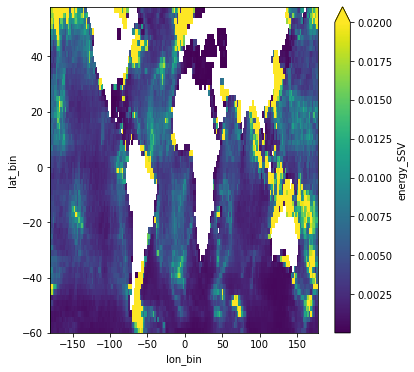

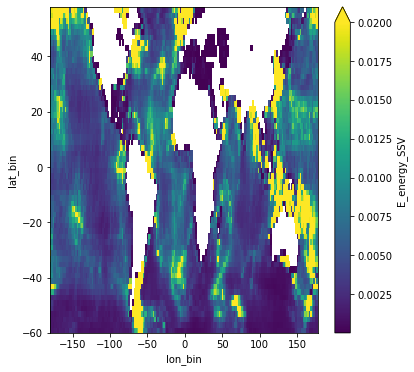

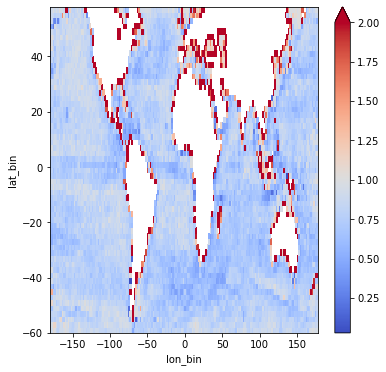

In [46]:
plt.figure(figsize=(6,6))
dsL[V].plot(y='lat_bin',vmax=0.02)
plt.figure(figsize=(6,6))
dsE['E_'+V].plot(y='lat_bin',vmax=0.02)
plt.figure(figsize=(6,6))
(dsL[V]/dsE['E_'+V]).plot(y='lat_bin',vmax=2,cmap='coolwarm')

In [26]:
#ds = xr.merge([dsE,dsL.rename({V:'L_'+V})])
ds = ds_binned
ds

<xarray.DataArray 'E_energy' (lon_bin: 179, lat_bin: 59)>
dask.array<where, shape=(179, 59), dtype=float64, chunksize=(179, 59), chunktype=numpy.ndarray>
Coordinates:
  * lon_bin  (lon_bin) float64 -179.0 -177.0 -175.0 -173.0 ... 173.0 175.0 177.0
  * lat_bin  (lat_bin) float64 -59.0 -57.0 -55.0 -53.0 ... 51.0 53.0 55.0 57.0

In [27]:
ds.to_netcdf('/home1/datawork/zcaspar/mit4320/%s_Eta_hf_binned_dl%s.nc'%(V,str(dl)))

In [28]:
#client.restart()
#
cluster.close()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/